In [113]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image

In [130]:
data_dir = '/Users/mik/Desktop/bubble_files/data/wrench_calibration_data/bubbles_wrench_calibration'
save_dir = '/Users/mik/Desktop'

In [115]:
data_dir_name = data_dir.split('/')[-1]
dl_path = os.path.join(data_dir, '{}_DataLegend.csv'.format(data_dir_name))

data_legend = pd.read_csv(dl_path)

In [116]:
data_legend

,Time,Sequence,SequenceIndx,FileCode,JointState
0,1.633963e+09,0,0,1,"(-0.5369699149127587, 0.6140259044641694, -0.0..."
1,1.633963e+09,0,1,2,"(-0.5266811581751809, 0.47277060182617925, -0...."
2,1.633963e+09,0,2,3,"(-0.5630559772318644, 0.39153799006919476, -0...."
3,1.633963e+09,0,3,4,"(-0.4463643210039671, 0.7990854066013031, -0.0..."
4,1.633963e+09,0,4,5,"(-0.4451843541839928, 0.6692488532902265, -0.0..."
...,...,...,...,...,...
751,1.633966e+09,13,49,752,"(-0.44512892710843877, 0.6692004369841116, -0...."
752,1.633966e+09,13,50,753,"(-0.44642687862218017, 0.7990793545630387, -0...."
753,1.633966e+09,13,51,754,"(-0.563042315230812, 0.39148436068277026, -0.0..."
754,1.633966e+09,13,52,755,"(-0.5265981674419994, 0.4727329713275924, -0.0..."


In [117]:
def load_wrench(fc, scene_name):
    wrench_dir = os.path.join(data_dir, scene_name, 'wrenches')
    wrench_file_path = os.path.join(wrench_dir, '{}_wrench_{:06}.csv'.format(scene_name, fc))
    wrench_df = pd.read_csv(wrench_file_path)
    return wrench_df

def load_tfs(fc, scene_name):
    tfs_dir = os.path.join(data_dir, scene_name, 'tfs')
    tfs_file_path = os.path.join(tfs_dir, 'recorded_tfs_{:06}.csv'.format(fc))
    tfs_df = pd.read_csv(tfs_file_path)
    return tfs_df

In [118]:
load_wrench(1, 'wrench_scene')

,header.seq,header.stamp.secs,header.stamp.nsecs,header.frame_id,wrench.force.x,wrench.force.y,wrench.force.z,wrench.torque.x,wrench.torque.y,wrench.torque.z
0,3720,0,0,med_kuka_link_ee,-0.007926,1.270768,-0.922795,-0.740841,0.059080,0.420241
1,0,0,0,grasp_frame,-1.270768,-0.007930,-0.922795,-0.059077,-0.740841,0.420241
2,0,1633963119,870810270,med_base,-0.003582,1.278864,0.911569,0.748629,0.052356,-0.407125


In [119]:
load_tfs(4,'wrench_scene')

,Unnamed: 0,parent_frame,child_frame,x,y,z,qx,qy,qz,qw


In [120]:
def load_data(ref_frame='med_kuka_link_ee'):
    filecodes = data_legend['FileCode']
    scene_name = 'wrench_scene'
    all_data = []
    tfs_columns = ['parent_frame', 'child_frame', 'x', 'y', 'z', 'qx', 'qy', 'qz', 'qw']
    wrench_columns = ['wrench.force.x', 'wrench.force.y', 'wrench.force.z', 'wrench.torque.x', 'wrench.torque.y', 'wrench.torque.z']
    data_columns = ['fc'] + tfs_columns + wrench_columns 
    for i, fc in enumerate(tqdm(filecodes)):
        sequence_i = data_legend['Sequence'][i]
        sequence_indx_i = data_legend['SequenceIndx'][i]
        time_i = data_legend['Time'][i]
        wrenches_i = load_wrench(fc, scene_name)
        tfs_i = load_tfs(fc, scene_name)
        tf_i = tfs_i.loc[tfs_i['child_frame'] == ref_frame]
        wrench_i = wrenches_i.loc[wrenches_i['header.frame_id'] == ref_frame]
        tf_data_i = tf_i[tfs_columns].reset_index(drop=True)
        wrench_data_i = wrench_i[wrench_columns].reset_index(drop=True)
#         import pdb; pdb.set_trace()
        data_i = pd.concat([tf_data_i,wrench_data_i],axis=1)
        data_i['FileCode'] = fc
        data_i['Sequence'] = sequence_i
        data_i['SequenceIndx'] = sequence_indx_i
        data_i['Time'] = time_i
        all_data.append(data_i)
    df = pd.concat(all_data, ignore_index=True)
    wrapped_indxs = df['SequenceIndx'] % (27*2)
    mask = wrapped_indxs//27
    df['PositionIndx'] = wrapped_indxs * ((-1)*(mask-1)) + mask*(27*2-1-wrapped_indxs)
    return df
        
        
        
    

In [121]:
all_data = load_data()

100%|██████████| 756/756 [00:07<00:00, 101.94it/s]


In [122]:
test_grid = np.array(np.meshgrid([0,1,2], [0,1,2], [0,1,2])).T.reshape(-1,3)
test_grid.shape

(27, 3)

In [123]:
xyz_indx_grid = test_grid[:,[0,2,1]]
xyz_indx_grid_reversed = np.flip(xyz_indx_grid, axis=0)
xyz_indxs = np.concatenate([xyz_indx_grid, xyz_indx_grid_reversed])

In [124]:
all_data.SequenceIndx

0       0
1       1
2       2
3       3
4       4
       ..
751    49
752    50
753    51
754    52
755    53
Name: SequenceIndx, Length: 756, dtype: int64

In [125]:
# add indexes so we know the point it is
all_data['x_indx'] = 0
all_data['y_indx'] = 0
all_data['z_indx'] = 0
all_data['x_val'] = 0
all_data['y_val'] = 0
all_data['z_val'] = 0

In [126]:
all_data['x_indx'] = xyz_indxs[all_data['SequenceIndx'],0]
all_data['y_indx'] = xyz_indxs[all_data['SequenceIndx'],1]
all_data['z_indx'] = xyz_indxs[all_data['SequenceIndx'],2]

In [127]:
all_data.loc[all_data.x_indx == 0, 'x_val'] = .45
all_data.loc[all_data.x_indx == 1, 'x_val'] = .55
all_data.loc[all_data.x_indx == 2, 'x_val'] = .65
all_data.loc[all_data.y_indx == 0, 'y_val'] = -.3
all_data.loc[all_data.y_indx == 1, 'y_val'] = 0
all_data.loc[all_data.y_indx == 2, 'y_val'] = .3
all_data.loc[all_data.z_indx == 0, 'z_val'] = .3
all_data.loc[all_data.z_indx == 1, 'z_val'] = .4
all_data.loc[all_data.z_indx == 2, 'z_val'] = .5

In [128]:
all_data['PositionIndx'] = all_data.z_indx + 3*all_data.x_indx + 9*all_data.y_indx

<ipython-input-131-50834b410d89>:13: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
<ipython-input-131-50834b410d89>:13: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
<ipython-input-131-50834b410d89>:13: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
<ipython-input-131-50834b410d89>:13: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
<ipython-input-131-5

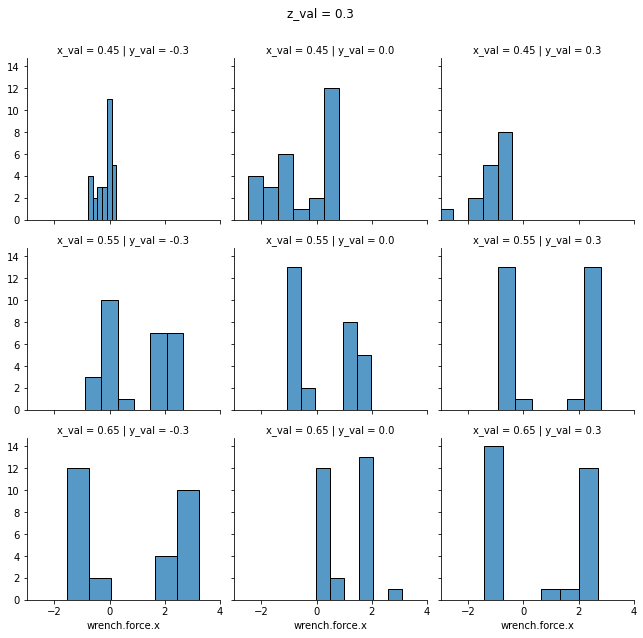

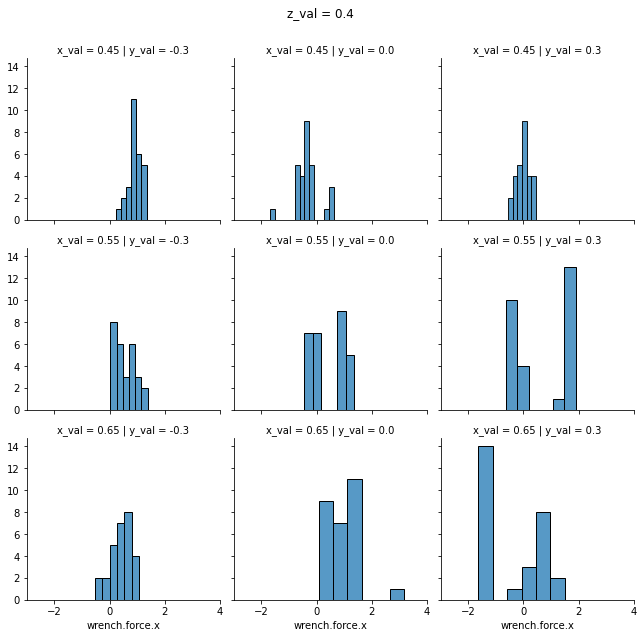

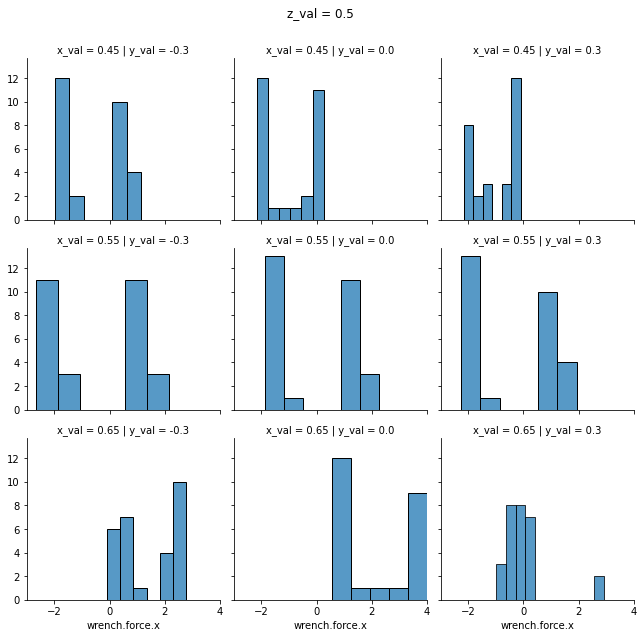

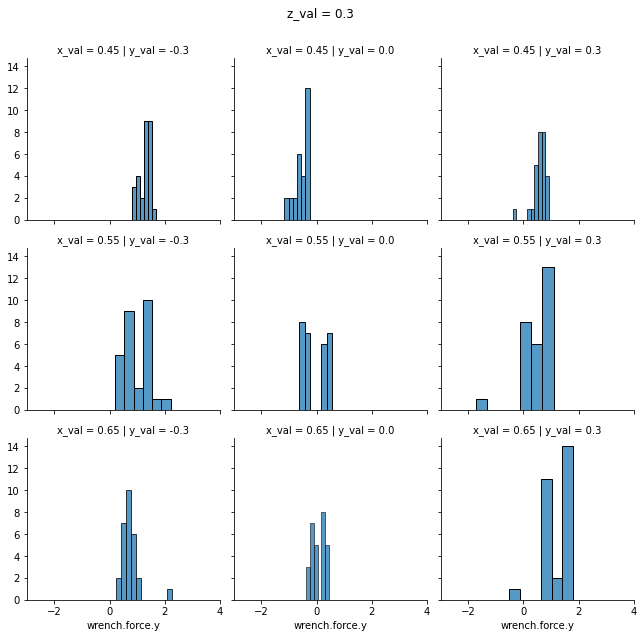

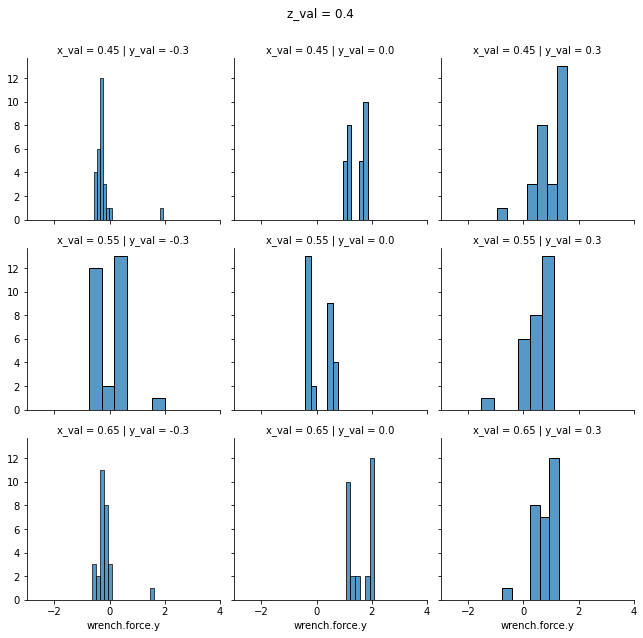

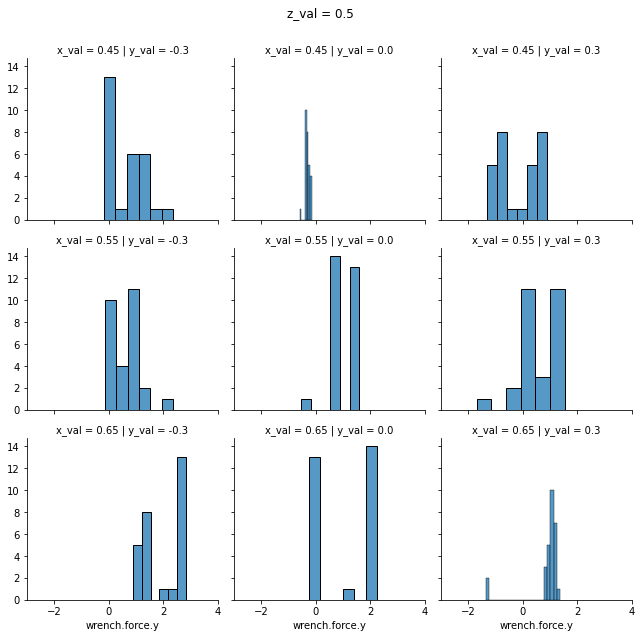

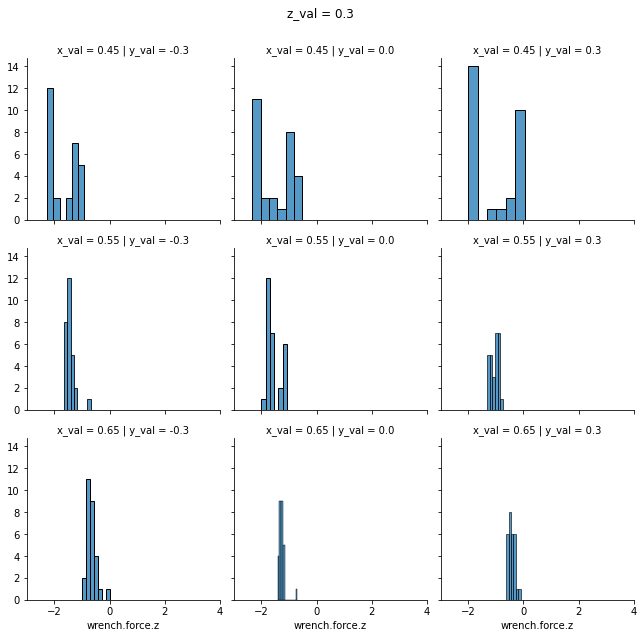

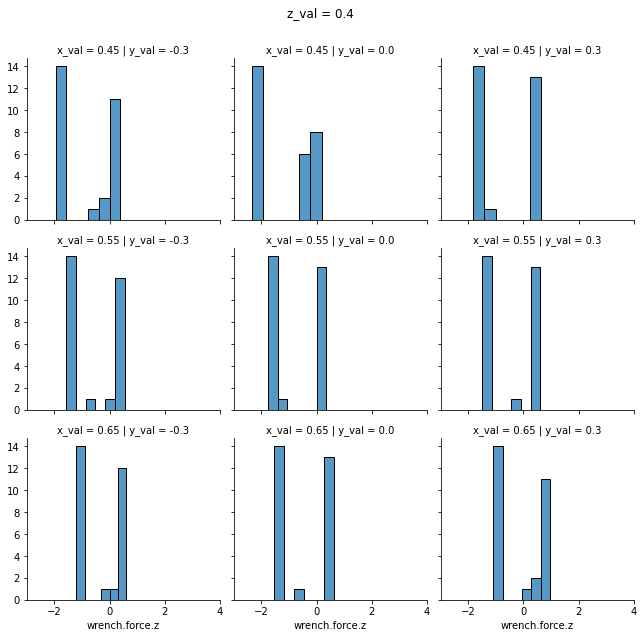

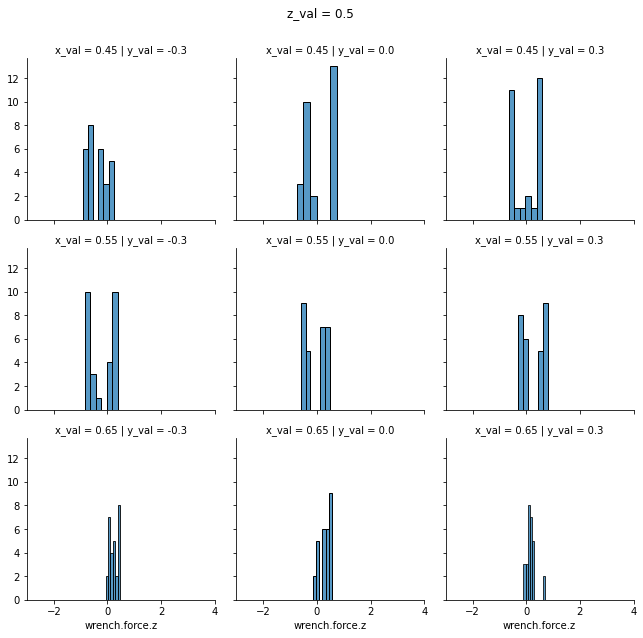

In [131]:

topic_names = ['wrench.force.x', 'wrench.force.y', 'wrench.force.z']
for topic_name in topic_names:
    z_vals = np.unique(all_data.z_val)
    imgs = []
    for i, z_val in enumerate(z_vals):
        g = sns.FacetGrid(all_data[all_data.z_val == z_val], col='y_val', row='x_val')
        g.map(sns.histplot, topic_name)
        g.set(xlim=(-3, 4))
        g.fig.subplots_adjust(top=0.9)
        g.fig.suptitle('z_val = {}'.format(z_val))
        fig = g.fig
        fig.canvas.draw()
        data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
        data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        imgs.append(data)

    big_img = np.concatenate(imgs, axis=1)

    img = Image.fromarray(big_img);

    img_name = topic_name.replace('.','_')
    save_path = os.path.join(save_dir, '{}.png'.format(img_name))
    img.save(save_path)
    

<ipython-input-133-ee7e8432cb28>:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


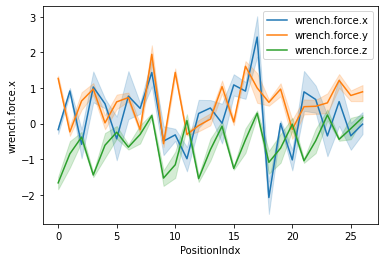

In [133]:
ys = ['wrench.force.x','wrench.force.y','wrench.force.z']
fig, ax = plt.subplots()
for y in ys:
    sns.lineplot(data=all_data,x='PositionIndx', y=y, ax=ax, label=y)
ax.legend()
fig.show()
save_path = os.path.join(save_dir, '{}.png'.format('time_plot_position_indx'))
plt.savefig(save_path)

